In [5]:
import warnings

%load_ext autoreload
%autoreload 2

warnings.filterwarnings("ignore") 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import io
import os
import torch
import requests
import numpy as np
import torchvision.models as models
import matplotlib.pyplot as plt

from saliency.gradcam import GradCAM, GradCAMpp
from saliency.utils import visualize_cam
from visualization.visualization import visualize_mask
from PIL import Image

In [7]:
# Initialize a model, model_dict and GradCAM++
vgg = models.vgg16(pretrained=True)
vgg = torch.load('data/trained_model.pt', map_location=torch.device('cpu'))
vgg.eval()
vgg.double()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
model_dict = dict(
    activation_function='sigmoid',
    type='vgg',
    arch=vgg, 
    layer_name='layer1',
    input_size=(224, 224),
    verbose=True
)
Gcpp = GradCAMpp(model_dict)

In [9]:
# Params for entire training set
X_mean = np.array([0.00126822, 0.00194388, 0.00209815])
X_std = np.array([0.00302834, 0.00460108, 0.00478389])

In [10]:
import h5py
import joblib
import torchvision.transforms as transforms
import nibabel as nib
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from skimage import transform


class UnprocessedDataset(Dataset):
    def __init__(self, root_dir):
        self.files = os.listdir(root_dir)
        self.files = [file for file in self.files if file[-4:] != ".csv"]
        self.root_dir = root_dir
    
    def __len__(self):
        return len(self.files)
    
    def __get_file_path(self, idx, postfix):
        return self.root_dir + "/" + self.files[idx] + "/" + self.files[idx] + "_" + postfix + ".nii"
    
    def __getitem__(self, index):
        if type(index) == tuple:
            idx, s = index
        else:
            idx, s = index, slice(None, None)
        images = [
            nib.load(self.__get_file_path(idx, postfix)) 
            for postfix in ["flair", "t1", "t2", "t1ce"]
        ]
        images = np.array([np.asanyarray(image.dataobj) for image in images])
        images = np.swapaxes(images, 0, 3)
        images = images[s]
        return images


def load_HDF5_img(path: str):
    """Load .hdf5 image as PIL Image"""
    assert path.endswith('.h5'), 'file must have hdf5-format'
    with h5py.File(path, 'r') as h5_img:
        assert 'image' in h5_img.keys()
        return Image.fromarray(h5_img['image'][:, :, :3], 'RGB')
    
    
def transform_img_old(img, min_img_size=224) -> torch.Tensor:
    """Preprocess using a transform pipeline"""
    to_pipeline = [
        transforms.Resize(min_img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[1/2]*3, std=[1/5]*3),
    ]
    transform_pipeline = transforms.Compose(to_pipeline)
    img_transformed = transform_pipeline(img).unsqueeze(0)
    return Variable(img_transformed)


def transform_img(img, mean, std):
    img_z_trans = (img[:, :, :-1] - mean) / std
    ttensor = torch.tensor(img_z_trans).permute(2, 0, 1)
    return Variable(ttensor[None, :, :, :]).double()


def mock_transform(img):
    return transform_img(img, 0, 1)


def transform_datapoint(datapoint, mean, std):
    datapoint = transform.resize(datapoint, (224, 224, 3))
    datapoint = (datapoint - mean) / std
    datapoint = np.moveaxis(datapoint, 2, 0)
    return torch.tensor(datapoint[None, :, :, :])

In [12]:
import os
from scipy.signal import resample_poly
from tqdm import tqdm


# Transform and GradCAM++ images
training_data = UnprocessedDataset("data/sample_volume")
class_index = 0 # tumor?
slice_masks = []
sample_volume = training_data[0]
transformed_imgs = []
for brain_slice in tqdm(sample_volume): # Sample volume
    #img_transformed = transform_img(brain_slice, X_mean, X_std)
    img_transformed = transform_datapoint(brain_slice, X_mean, X_std)
    transformed_imgs.append(img_transformed)
    mask, _ = Gcpp(img_transformed, class_idx=class_index)
    np_mask = mask[0, 0, :].numpy()
    slice_masks.append(np_mask)
mask_3d = np.stack(slice_masks)

100%|██████████| 155/155 [09:30<00:00,  3.68s/it]


ValueError: only one element tensors can be converted to Python scalars

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


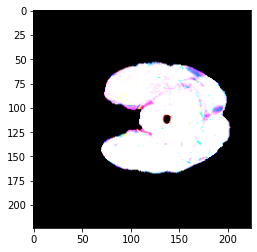

In [13]:
plt.imshow(np.moveaxis(np.array(transformed_imgs[40][0]), 0, 2))
plt.show()

### Computing 3D brain contour  
Might be helpful for visualizing where in the particular brain the network sees areas of interest.

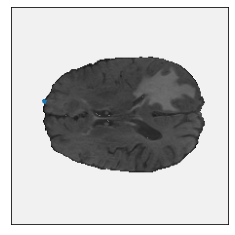

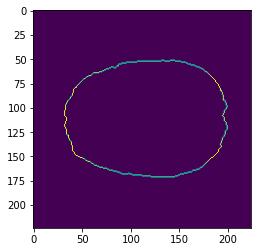

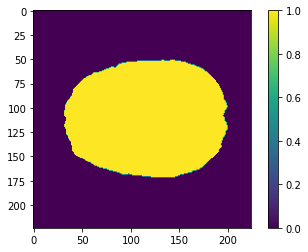

In [14]:
import scipy.ndimage as ndimage
from skimage import measure
from matplotlib import image


def rgb_to_grayscale(rgb: np.ndarray) -> np.ndarray:
    """RGB to graysc of ndarray using PIL."""
    vol_max = rgb.max()
    np_normalized = (rgb / vol_max * 255).astype(np.uint8)
    r = Image.fromarray(np_normalized).convert('L')
    return np.array(r)


def contour_matrix(r: np.ndarray, find_thres=200) -> np.ndarray:
    """2D contours of grayscale image r."""
    contours = measure.find_contours(r, find_thres)
    contour_matrix = np.zeros(r.shape)
    if not len(contours):
        return contour_matrix
    for x, y in contours[0]:
        contour_matrix[round(x), round(y)] = 1
    return contour_matrix
    
    
def contour_matrix_mask(contour_matrix: np.ndarray) -> np.ndarray:
    """Binary mask on brain from 2D contour matrix."""
    return ndimage.binary_fill_holes(contour_matrix) # ~ to invert


def contour_tensor_mask(contour_tensor: np.ndarray) -> np.ndarray:
    """Binary mask on brain from 3D contour tensor."""
    return np.apply_along_axis(contour_matrix_mask, 1, contour_tensor)


def brain_hull(volume: np.ndarray) -> np.ndarray:
    """3D contours of volume represented as a sparse matrix of volume shape."""
    contour_tensor = []
    for idx in range(volume.shape[0]): # idx x 240 x 240 x 4
        img = volume[idx, :, :, :-1]
        r = rgb_to_grayscale(img)
        contour_tensor.append(contour_matrix(r))
    return np.array(contour_tensor)


# Preprocess sample
idx = 60
img = np.array(transformed_imgs[80][0].permute(1, 2, 0)) #
#img = sample_volume[idx, :, :, :-1]
r = rgb_to_grayscale(img)

contours = measure.find_contours(r, 1)
fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=4)
    
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()
    
contour_m = contour_matrix(r)
plt.imshow(contour_m)
plt.show()

plt.imshow(contour_matrix_mask(contour_m))
plt.colorbar()
plt.show()

In [15]:
transformed_imgs_np = np.array([
    np.array(img[0].permute(1, 2, 0)) for img in transformed_imgs
])
hull = brain_hull(transformed_imgs_np)
tensor_mask = contour_tensor_mask(hull)

In [171]:
hull.shape, tensor_mask.shape

((155, 224, 224), (155, 224, 224))

In [56]:
# Downsample volume hull
hull_downsampled = np.nan_to_num(hull.copy())
for k in range(3):
    hull_downsampled = resample_poly(hull_downsampled, 1, 8, axis=k)
    
# Downsample brain volume activations
mask_downsampled = np.nan_to_num(mask_3d.copy())
for k in range(3):
    mask_downsampled = resample_poly(mask_downsampled, 1, 8, axis=k)
    
# Downsample brain volume mask, inside brain activation only
mask_downsampled_inside = np.nan_to_num(mask_3d.copy())
mask_downsampled_inside[~tensor_mask] = 0
for k in range(3):
    mask_downsampled_inside = resample_poly(mask_downsampled_inside, 1, 8, axis=k)

In [52]:
def brain_hull_idxs(hull_tensor: np.ndarray):
    """x, y, z of 3D contours of volume for 3d mesh gen."""
    return np.where(hull_tensor == 1)

hull_downsampled[np.where(hull_downsampled > 0.01)] = 1
hull_x, hull_y, hull_z = brain_hull_idxs(hull_downsampled)

In [57]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_daq as daq
import plotly.graph_objects as go

from dash.dependencies import Input, Output, State
from visualization.visualization import create_volume


# Normalize
inside_squared = mask_downsampled_inside**2
inside_squared /= inside_squared.flatten().max()
# Prep fig
nd_slice = slice(0, mask_downsampled.shape[1], 1)

fig_data = {
    'all-activation': create_volume(mask_downsampled, ndgrid_idxs=nd_slice),
    'inside-activation': create_volume(mask_downsampled_inside, ndgrid_idxs=nd_slice),
    'inside-activation-squared': create_volume(inside_squared, ndgrid_idxs=nd_slice),
    'brain-cloud': create_volume(
        hull_downsampled, ndgrid_idxs=nd_slice, 
        colorscale='Greys', opacity=0.05, n_surface=10
    ),
    'brain-mesh': go.Mesh3d(
        x=hull_x, y=hull_y, z=hull_z, 
        color='lightpink', opacity=0.30, alphahull=1
    )
}

fig = go.Figure()
fig.add_trace(fig_data['inside-activation-squared'])
# Init dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(
        id="graph", 
        figure=fig, 
        style={'height': '800px'}
    ),
    daq.ToggleSwitch(
        label='Brain contours',
        labelPosition='bottom',
        value=False,
        size=80,
        id='contour-toggle',
    )
])


@app.callback(
    Output("graph", "figure"), [Input("contour-toggle", "value")]
)
def toggle_contours(toggle_val):
    global fig_data
    fig = go.Figure(data=fig_data['inside-activation-squared'])
    if toggle_val:
        fig.add_trace(fig_data['brain-cloud'])
        #fig.add_trace(fig_data['brain-mesh'])
    return fig

    
app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [24/Mar/2021 14:34:22] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2021 14:34:23] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2021 14:34:23] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2021 14:34:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2021 14:35:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2021 14:35:21] "POST /_dash-update-component HTTP/1.1" 200 -


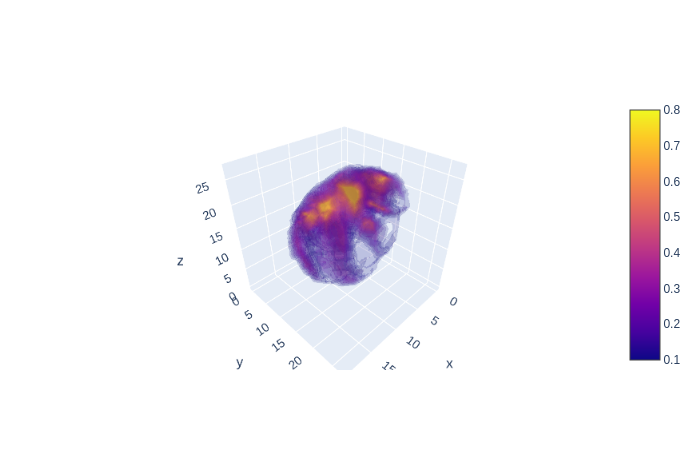

In [187]:
fig.show(renderer='png')